In [66]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
import os
import datetime as dt

from copy import deepcopy

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

# logistic regression is our favourite model ever
from sklearn import linear_model

# used to calculate AUROC/accuracy
from sklearn import metrics

# local utils
import utils

import xgboost as xgb

import pickle

# default colours/marker/linestyles for prettier plots
col = [[0.9047, 0.1918, 0.1988],
    [0.2941, 0.5447, 0.7494],
    [0.3718, 0.7176, 0.3612],
    [1.0000, 0.5482, 0.1000],
    [0.4550, 0.4946, 0.4722],
    [0.6859, 0.4035, 0.2412],
    [0.9718, 0.5553, 0.7741],
    [0.5313, 0.3359, 0.6523]];
marker = ['v','o','d','^','s','o','+']
ls = ['-','-','-','-','-','s','--','--']


%matplotlib inline

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 20, 'xtick.labelsize': 16, 'ytick.labelsize': 16})

## Load data

In [67]:
print('=== MIMIC ===')
X_mimic = pd.read_csv('X_mimic_apsiii.csv.gz', sep=',', index_col=0)

var_other = ['hospitalid', 'death', 'hosp_los', 'ventdays']
df_mimic = X_mimic[var_other]

# convenient reference to death column
y_mimic = X_mimic['death'].values

# drop everything other than APS III
X_mimic = X_mimic['apsiii'].values.reshape([X_mimic.shape[0],1])

print('{} observations. Outcome rate: {:2.2f}%.'.format(
        X_mimic.shape[0], 100.0*np.mean(y_mimic)))

print('=== eICU ===')
X_eicu = pd.read_csv('X_eicu_apsiii.csv.gz', sep=',', index_col=0)

hosp_to_keep = X_eicu['hospitalid'].value_counts()
hosp_to_keep = hosp_to_keep[hosp_to_keep>=100].index.values
print('Retaining {} of {} hospitals.'.format(len(hosp_to_keep), X_eicu['hospitalid'].nunique()))

X_eicu = X_eicu.loc[X_eicu['hospitalid'].isin(hosp_to_keep), :]

var_other = ['hospitalid', 'death', 'hosp_los', 'ventdays']
df_eicu = X_eicu[var_other]

# convenient reference to death column
y_eicu = X_eicu['death'].values

# drop everything other than APS III
X_eicu = X_eicu['apsiii'].values.reshape([X_eicu.shape[0],1])

print('{} observations. Outcome rate: {:2.2f}%.'.format(
        X_eicu.shape[0], 100.0*np.mean(y_eicu)))

=== MIMIC ===
27940 observations. Outcome rate: 9.57%.
=== eICU ===
Retaining 119 of 179 hospitals.
67544 observations. Outcome rate: 7.47%.


## Logistic Regression

In [68]:
mdl_filename = 'lr_mdl_apsiii.pkl'
if os.path.exists(mdl_filename):
    with open(mdl_filename, 'rb') as fp:
        lr_mdl = pickle.load(fp)
else:
    np.random.seed(71017)

    X = X_mimic
    y = y_mimic

    base_mdl = linear_model.LogisticRegressionCV(Cs=10, penalty='l2', cv=5)

    estimator = Pipeline([("imputer", Imputer(missing_values='NaN',
                                      strategy="mean",
                                      axis=0)),
                  ("scaler", StandardScaler()),
                  ('model', base_mdl)]) 

    # train model
    lr_mdl = estimator.fit(X, y)
    lr_prob = estimator.predict_proba(X)[:,1]
    auc = metrics.roc_auc_score(y, lr_prob)
    print('Training set AUROC: {:0.3f}'.format(auc))
    with open(mdl_filename, 'wb') as fp:
        pickle.dump(lr_mdl, fp)

## Load MIMIC-III performance

In [69]:
cv_perf = pd.read_csv('model-performance-cv-soi.csv', header=0, sep=',')
cv_perf.set_index('model', inplace=True)
cv_perf

,auc,smr
model,,
l2,0.752926,1.000519
xgb,0.746606,0.999796


###  Evaluate model on eICU

In [70]:
lr_prob = lr_mdl.predict_proba(X_eicu)[:,1]

# add predictions to dataframe
df_eicu['prob'] = lr_prob

# overall auroc
auc = metrics.roc_auc_score(df_eicu['death'], df_eicu['prob'])
print('eICU overall AUROC: {:0.3f}'.format(auc))
print('eICU overall SMR:   {:0.3f}'.format(df_eicu['death'].sum() / df_eicu['prob'].sum()))

eICU overall AUROC: 0.819
eICU overall SMR:   0.682


## Helper functions

In [71]:
def hospital_stats(x, outcome='death'):
    d = {}
    # calculate SMR
    d['count'] = x[outcome].count()
    d['outcome'] = x[outcome].sum()
    
    d['smr'] = x[outcome].sum() / x['prob'].sum()
    if len(np.unique(x[outcome]))<=1:
        d['auc'] = np.nan
    else:
        d['auc'] = metrics.roc_auc_score(x[outcome], x['prob'])
    return pd.Series(d)

In [72]:
# scatter plot grouped by hospital
h_stats = df_eicu.groupby('hospitalid').apply(hospital_stats)
h_stats.head()

,auc,count,outcome,smr
hospitalid,,,,
58,0.852234,100.0,3.0,0.284671
59,0.926923,161.0,5.0,0.447138
63,0.928123,447.0,19.0,0.519885
66,0.891614,322.0,6.0,0.229247
67,0.705405,116.0,5.0,0.426496


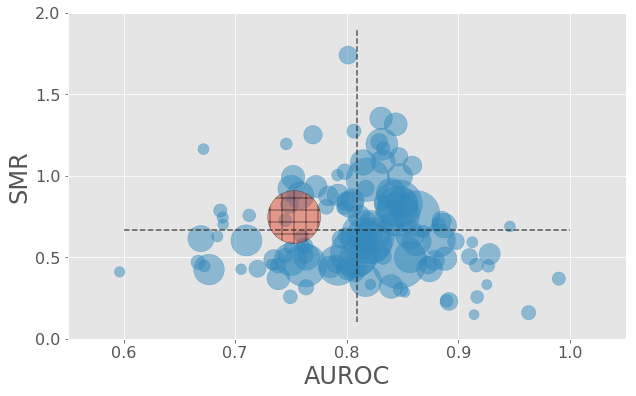

Average AUROC: 0.809
Average SMR: 0.670


In [85]:
# create a bubble plot AUROC vs SMR
plt.figure(figsize=[10,6])
plt.scatter( h_stats['auc'], h_stats['smr'],
            s=np.ceil(h_stats['count']),
            marker='o', edgecolors=None, alpha=0.5, color='#348ABD' )

# add original performance
plt.scatter( cv_perf.loc['l2', 'auc'], cv_perf.loc['xgb', 'auc'],
            s=X_mimic.shape[0]/10,
            marker='o', alpha=0.5, color='#E24A33',
            hatch='+', edgecolors='k')

plt.plot( (h_stats['auc']).mean()*np.ones(2), [0.1,1.9], '--', color=[0.1,0.1,0.1],alpha=0.7)
plt.plot( [0.6,1.0], (h_stats['smr']).mean()*np.ones(2), '--', color=[0.1,0.1,0.1],alpha=0.7)

plt.yticks(np.linspace(0, 2, 5))
plt.xticks(np.linspace(0.6, 1, 5))
plt.ylim([0,2])
plt.xlim([0.55,1.05])
plt.ylabel('SMR')
plt.xlabel('AUROC')
plt.show()

print('Average AUROC: {:0.3f}'.format((h_stats['auc']).mean()))
print('Average SMR: {:0.3f}'.format((h_stats['smr']).mean()))

### Normalize eICU hospital wise before applying MIMIC model

In [74]:
lr_mdl_hn = deepcopy(lr_mdl)

prob = np.zeros(X_eicu.shape[0])

hosp_list = df_eicu['hospitalid'].unique()
for h in hosp_list:
    idxKeep = df_eicu['hospitalid'] == h
    
    # get current hosp data
    X_current = X_eicu[idxKeep, :]
    
    # refit the imputer
    lr_mdl_hn.named_steps['imputer'] = lr_mdl_hn.named_steps['imputer'].fit(X_current)
    
    # work-around for imputer dropping columns with all NaN
    X_current_t = lr_mdl_hn.named_steps['imputer'].transform(X_current)
    
    idxAllNan = np.isfinite(X_eicu[idxKeep, :]).sum(axis=0)
    if np.any(idxAllNan==0):
        X_fix = np.zeros([X_current.shape[0], X_eicu.shape[1]])
        for i, idx in enumerate(np.where(idxAllNan>0)[0]):
            X_fix[:, idx] = X_current_t[:, i]
    else:
        X_fix = X_current_t
    
    # refit the scaler
    lr_mdl_hn.named_steps['scaler'] = lr_mdl_hn.named_steps['scaler'].fit(X_fix)
    
    X_fix = lr_mdl_hn.named_steps['scaler'].transform(X_fix)
    
    curr_prob = lr_mdl_hn.named_steps['model'].predict_proba(X_fix)[:,1]
    
    prob[idxKeep] = curr_prob
    
# add predictions to dataframe
df_eicu['prob_norm'] = prob

# re-calculate hospital stats - scatter plot grouped by hospital
h_stats_normed = df_eicu.drop('prob',axis=1).rename({'prob_norm': 'prob'}, axis=1
                                                   ).groupby('hospitalid').apply(hospital_stats)

# overall auroc
auc = metrics.roc_auc_score(df_eicu['death'], df_eicu['prob_norm'])
print('eICU overall AUROC: {:0.3f}'.format(auc))
print('eICU overall SMR:   {:0.3f}'.format(df_eicu['death'].sum() / df_eicu['prob_norm'].sum()))

eICU overall AUROC: 0.813
eICU overall SMR:   0.779


### Retrain model for each hospital

In [75]:
# normalize eICU hospital wise before applying MIMIC model
lr_mdl_hn = deepcopy(lr_mdl)

prob = np.zeros(X_eicu.shape[0])

hosp_list = df_eicu['hospitalid'].unique()

for h in hosp_list:
    idxKeep = df_eicu['hospitalid'] == h
    
    if len(np.unique(y_eicu[idxKeep]))<2:
        prob[idxKeep] = np.nan
        continue
    
    # get current hosp data
    X_current = X_eicu[idxKeep, :]
    
    # refit the imputer
    lr_mdl_hn.named_steps['imputer'] = lr_mdl_hn.named_steps['imputer'].fit(X_current)
    
    # work-around for imputer dropping columns with all NaN
    X_current_t = lr_mdl_hn.named_steps['imputer'].transform(X_current)
    
    idxAllNan = np.isfinite(X_eicu[idxKeep, :]).sum(axis=0)
    if np.any(idxAllNan==0):
        X_fix = np.zeros([X_current.shape[0], X_eicu.shape[1]])
        for i, idx in enumerate(np.where(idxAllNan>0)[0]):
            X_fix[:, idx] = X_current_t[:, i]
    else:
        X_fix = X_current_t
    
    # refit the scaler
    lr_mdl_hn.named_steps['scaler'] = lr_mdl_hn.named_steps['scaler'].fit(X_fix)
    
    X_fix = lr_mdl_hn.named_steps['scaler'].transform(X_fix)
    
    # refit the model
    
    if 'LogisticRegression' in str(type(lr_mdl_hn.named_steps['model'])):
        # don't do CV again, just use the C_ penalty
        l2penalty = lr_mdl_hn.named_steps['model'].C_[0]
        new_model = linear_model.LogisticRegression(penalty='l2', C=l2penalty).fit(X_fix, y_eicu[idxKeep])
    else:
        new_model = lr_mdl_hn.named_steps['model'].fit(X_fix, y_eicu[idxKeep])
    
    curr_prob = new_model.predict_proba(X_fix)[:,1]
    
    prob[idxKeep] = curr_prob
    
# add predictions to dataframe
df_eicu['prob_retrain'] = prob

# re-calculate hospital stats - scatter plot grouped by hospital
h_stats_retrain = df_eicu.drop('prob',axis=1).rename({'prob_retrain': 'prob'}, axis=1
                                                   ).groupby('hospitalid').apply(hospital_stats)

# overall auroc
auc = metrics.roc_auc_score(df_eicu['death'], df_eicu['prob_norm'])
print('eICU overall AUROC: {:0.3f}'.format(auc))
print('eICU overall SMR:   {:0.3f}'.format(df_eicu['death'].sum() / df_eicu['prob_norm'].sum()))

eICU overall AUROC: 0.813
eICU overall SMR:   0.779


## Lines in direction of improvement

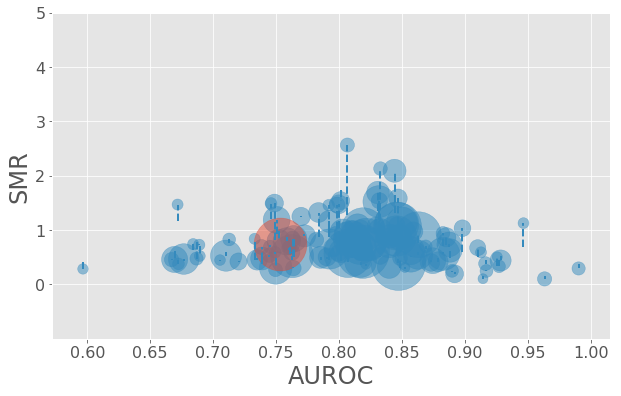

0.000 [0.000 - 0.000] AUROC improvement
-0.116 [-0.226 - 0.033] SMR improvement


In [76]:
# draw lines from original to renormed preds
plt.figure(figsize=[10,6])

for h in hosp_to_keep:
    plt.plot([h_stats.loc[h, 'auc'], h_stats_normed.loc[h, 'auc']],
             [h_stats.loc[h, 'smr'], h_stats_normed.loc[h, 'smr']],
            marker=None, linestyle='--', linewidth=2, color='#348ABd')
    
plt.scatter(h_stats_normed['auc'], h_stats_normed['smr'],
            s=np.ceil(h_stats_normed['count']),
            marker='o', edgecolors=None, alpha=0.5, color='#348ABD' )

# add original performance
plt.scatter( cv_perf.loc['l2', 'auc'], cv_perf.loc['l2', 'auc'],
            s=X.shape[0]/10,
         marker='o', edgecolors=None, alpha=0.5, color='#E24A33')

plt.yticks(np.arange(0, 6, 1))
plt.ylim([-1,5])
plt.ylabel('SMR')
plt.xlabel('AUROC')
plt.show()

auc_improvement = (h_stats_normed['auc'] - h_stats['auc'])
print('{:0.3f} [{:0.3f} - {:0.3f}] AUROC improvement'.format(
    auc_improvement.mean(), auc_improvement.quantile(0.25), auc_improvement.quantile(0.75)))

smr_improvement = - ((h_stats_normed['smr'] - h_stats['smr']))
print('{:0.3f} [{:0.3f} - {:0.3f}] SMR improvement'.format(
    smr_improvement.mean(), smr_improvement.quantile(0.25), smr_improvement.quantile(0.75)))

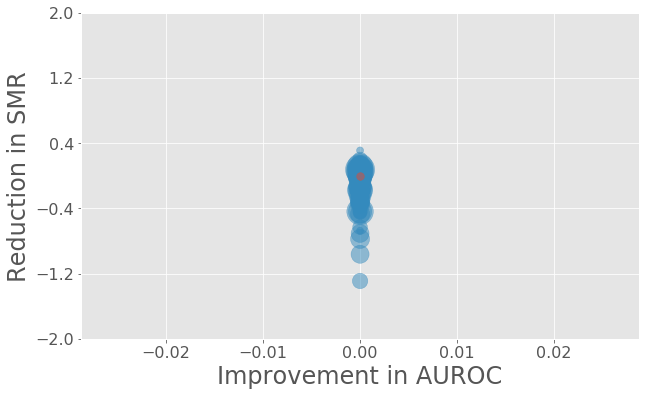

In [77]:
def auc_as_size(x):
    # ensure 0.75 -> 100 and 0.9 -> 1000
    x = x-0.75
    x = np.clip(x, 0, 0.9)
    x = x/0.9
    x = 3000*x+50
    return x

plt.figure(figsize=[10,6])
plt.scatter(-(h_stats['auc'] - h_stats_normed['auc']),
             h_stats['smr'] - h_stats_normed['smr'],
            s=auc_as_size(h_stats_normed['auc']),
            marker='o', edgecolors=None, alpha=0.5, color='#348ABD' )

# add original performance
plt.scatter( 0, 0, s=auc_as_size(cv_perf.loc['l2','auc']),
         marker='o', edgecolors=None, alpha=0.5, color='#E24A33')

plt.yticks(np.linspace(-2, 2, 6))
plt.ylim([-2,2])
plt.ylabel('Reduction in SMR')
plt.xlabel('Improvement in AUROC')
plt.show()

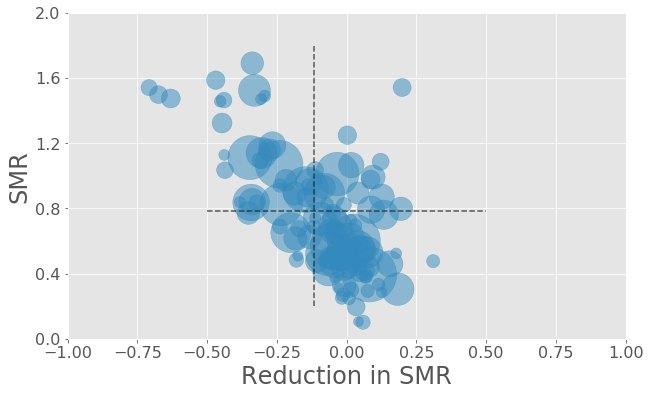

In [78]:
plt.figure(figsize=[10,6])
plt.scatter(h_stats['smr'] - h_stats_normed['smr'],
            h_stats_normed['smr'],
            s=np.ceil(h_stats_normed['count']),
            marker='o', edgecolors=None, alpha=0.5, color='#348ABD' )

# add original performance
#plt.scatter( cv_perf.loc['l2', 'auc'], cv_perf.loc['l2', 'auc'],
#            s=X.shape[0]/10,
#         marker='o', edgecolors=None, alpha=0.5, color='#E24A33')


plt.plot( [-0.5,.5], (h_stats_normed['smr']).mean()*np.ones(2), '--', color=[0.1,0.1,0.1],alpha=0.7)
plt.plot( (h_stats['smr'] - h_stats_normed['smr']).mean()*np.ones(2), [0.2, 1.8], '--', color=[0.1,0.1,0.1],alpha=0.7)


plt.yticks(np.linspace(0, 2.0, 6))
plt.ylim([0,2])
plt.xlim([-1,1])
plt.ylabel('SMR')
plt.xlabel('Reduction in SMR')
plt.show()

## Retrain once, on largest hospital, then predict

In [79]:
# normalize eICU hospital wise before applying MIMIC model
lr_mdl_hn = deepcopy(lr_mdl)

prob = np.zeros(X_eicu.shape[0])

hosp_list = df_eicu['hospitalid'].value_counts()
h = hosp_list.idxmax() # biggest hospital

idxKeep = df_eicu['hospitalid'] == h

# get current hosp data
X_current = X_eicu[idxKeep, :]

# refit the imputer
lr_mdl_hn.named_steps['imputer'] = lr_mdl_hn.named_steps['imputer'].fit(X_current)

# work-around for imputer dropping columns with all NaN
X_current_t = lr_mdl_hn.named_steps['imputer'].transform(X_current)

idxAllNan = np.isfinite(X_eicu[idxKeep, :]).sum(axis=0)
if np.any(idxAllNan==0):
    X_fix = np.zeros([X_current.shape[0], X_eicu.shape[1]])
    for i, idx in enumerate(np.where(idxAllNan>0)[0]):
        X_fix[:, idx] = X_current_t[:, i]
else:
    X_fix = X_current_t

# refit the scaler
lr_mdl_hn.named_steps['scaler'] = lr_mdl_hn.named_steps['scaler'].fit(X_fix)

X_fix = lr_mdl_hn.named_steps['scaler'].transform(X_fix)

# refit the model
if 'LogisticRegression' in str(type(lr_mdl_hn.named_steps['model'])):
    # don't do CV again, just use the C_ penalty
    l2penalty = lr_mdl_hn.named_steps['model'].C_[0]
    new_model = linear_model.LogisticRegression(penalty='l2', C=l2penalty).fit(X_fix, y_eicu[idxKeep])
else:
    new_model = lr_mdl_hn.named_steps['model'].fit(X_fix, y_eicu[idxKeep])

# now that we have new_model, apply to original data
X_current = lr_mdl_hn.named_steps['imputer'].transform(X_eicu)
X_current = lr_mdl_hn.named_steps['scaler'].transform(X_current)
prob = new_model.predict_proba(X_current)[:,1]

df_eicu['prob_retrain_eicu'] = prob

# re-calculate hospital stats - scatter plot grouped by hospital
h_stats_retrain_eicu = df_eicu.drop('prob',axis=1).rename({'prob_retrain_eicu': 'prob'}, axis=1
                                                   ).groupby('hospitalid').apply(hospital_stats)
h_stats_retrain_eicu.head()

,auc,count,outcome,smr
hospitalid,,,,
58,0.852234,100.0,3.0,0.194722
59,0.926923,161.0,5.0,0.234691
63,0.928123,447.0,19.0,0.306321
66,0.891614,322.0,6.0,0.130789
67,0.705405,116.0,5.0,0.277861


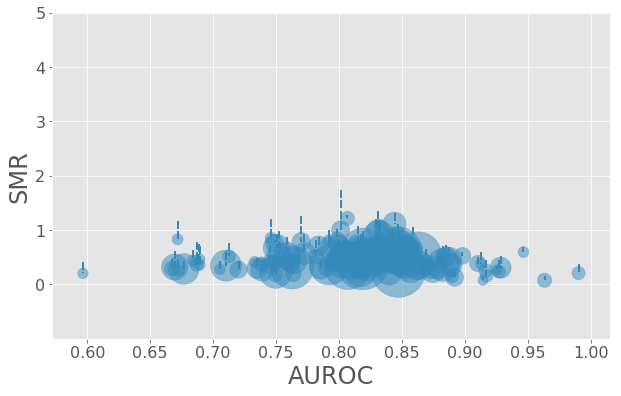

0.000 [0.000 - 0.000] AUROC improvement
0.206 [0.126 - 0.246] SMR improvement


In [80]:
# draw lines from original to retrained preds
plt.figure(figsize=[10,6])

for h in hosp_to_keep:
    plt.plot([h_stats['auc'], h_stats_retrain_eicu['auc']],
             [h_stats['smr'], h_stats_retrain_eicu['smr']],
            marker=None, linestyle='--', linewidth=2, color='#348ABd')
    
plt.scatter( h_stats_retrain_eicu['auc'], h_stats_retrain_eicu['smr'],
            s=np.ceil(h_stats_retrain_eicu['count']),
            marker='o', edgecolors=None, alpha=0.5, color='#348ABD' )

# add original performance
#plt.scatter( cv_perf.loc['l2', 'auc'], cv_perf.loc['l2', 'auc'],
#            s=X.shape[0]/10,
#         marker='o', edgecolors=None, alpha=0.5, color='#E24A33')

plt.yticks(np.arange(0, 6, 1))
plt.ylim([-1,5])
plt.ylabel('SMR')
plt.xlabel('AUROC')
plt.show()

auc_improvement = (h_stats_retrain_eicu['auc'] - h_stats['auc'])
print('{:0.3f} [{:0.3f} - {:0.3f}] AUROC improvement'.format(
    auc_improvement.mean(), auc_improvement.quantile(0.25), auc_improvement.quantile(0.75)))

smr_improvement = - ((h_stats_retrain_eicu['smr'] - h_stats['smr']))
print('{:0.3f} [{:0.3f} - {:0.3f}] SMR improvement'.format(
    smr_improvement.mean(), smr_improvement.quantile(0.25), smr_improvement.quantile(0.75)))

build a funnel plot models

```python
# create a funnel plot
idxKeep = h_stats['outcome']>=10

plt.figure(figsize=[10,6])
plt.scatter( h_stats.loc[idxKeep, 'count'], h_stats.loc[idxKeep, 'smr'],
            s=np.ceil(h_stats.loc[idxKeep, 'count']),
            marker='o', edgecolor=None, alpha=0.5, color='#348ABD' )

# draw 95% confidence intervals
# 95% CI = SMR_se * 1.96
xi = np.arange(10, 3000, 10)
plt.plot( xi, np.ones(xi.shape), '--', color=[0.2,0.2,0.2], linewidth=4, alpha=0.8)
plt.plot( xi, 1.0 + (np.sqrt(xi) / xi * 1.96), '--', color='#E24A33', linewidth=4, alpha=0.8 )
plt.plot( xi, 1.0 - (np.sqrt(xi) / xi * 1.96), '--', color='#E24A33', linewidth=4, alpha=0.8 )

plt.yticks([0, 1, 2, 3])
plt.ylim([-0.1,10])
plt.ylabel('SMR')
plt.xlabel('Number of ICU patients admitted')
plt.show()
```